# Compare to LORA database

# Setup and Info

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib_venn import venn2, venn2_circles
from rna_motif_library.plotting import (
    publication_style_ax,
    calculate_subplot_coordinates,
    merge_sequential_coords,
)

PLOT_PATH = "../figures/plots"

In [179]:
def load_and_fit_image_to_subplot(image_path, ax):
    """
    Load an image from file and stretch it to fit in a subplot.

    Parameters:
    -----------
    image_path : str
        Path to the image file
    subplot_coords : tuple
        Subplot coordinates as (left, bottom, width, height) in figure-relative units
    fig : matplotlib.figure.Figure
        The figure object
    ax : matplotlib.axes.Axes
        The axes object where the image will be placed

    Returns:
    --------
    matplotlib.image.AxesImage
        The image object that was added to the subplot
    """

    # Load the image
    try:
        img = mpimg.imread(image_path)
    except Exception as e:
        raise ValueError(f"Could not load image from {image_path}: {e}")

    # Clear the axes
    ax.clear()

    # Display the image stretched to fit the subplot
    img_plot = ax.imshow(img)

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    return img_plot

In [115]:
def add_motif_type_to_df(df):
    df["motif_1_type"] = df["motif_1_id"].str.split("-").str[0]
    df["motif_2_type"] = df["motif_2_id"].str.split("-").str[0]
    return df

In [163]:
def rename_motif_types(df):
    """Rename motif type values to more readable format.

    Args:
        df: DataFrame containing motif data

    Returns:
        DataFrame with renamed motif types
    """
    type_mapping = {
        "HELIX": "Helix",
        "SSTRAND": "Single Strand",
        "TWOWAY": "Two-way",
        "NWAY": "N-way",
        "HAIRPIN": "Hairpin",
    }

    df["motif_1_type"] = df["motif_1_type"].map(type_mapping)
    df["motif_2_type"] = df["motif_2_type"].map(type_mapping)
    return df

In [164]:
df = pd.read_json(
    "../../data/summaries/tertiary_contacts/lora/lora_compared_w_features.json"
)
df = df.query("motif_1_type != 'UNKNOWN' and motif_2_type != 'UNKNOWN'")
df = rename_motif_types(df)

In [117]:
df[["in_our_db", "in_their_db"]].value_counts()

in_our_db  in_their_db
1          1              2364
           0              1555
Name: count, dtype: int64

In [165]:
df.iloc[0]

motif_1_id                            TWOWAY-2-1-GAGG-CAC-1XJR-1
motif_2_id                        TWOWAY-4-3-CCGAGG-UACAG-1XJR-1
in_our_db                                                      1
in_their_db                                                    1
pdb_id                                                      1XJR
is_motif_1_unique                                              1
is_motif_2_unique                                              1
motif_1_type                                             Two-way
motif_2_type                                             Two-way
motif_1_size                                                 2-1
motif_2_size                                                 4-3
m_sequence_1                                            GAGG-CAC
m_sequence_2                                        CCGAGG-UACAG
num_base_base_hbonds                                           1
num_base_sugar_hbonds                                          1
num_base_phosphate_hbonds

# Plots

## Overlap between LORA and RSIA

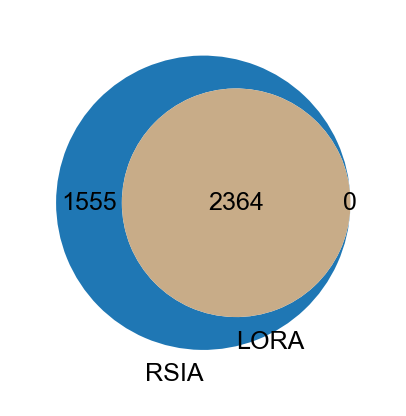

In [166]:
def plot_overlap_venn(df, ax):
    """
    Plot a Venn diagram showing overlap between RSIA and LORA.

    Args:
        df: DataFrame with 'in_our_db' and 'in_their_db' boolean columns
        ax: matplotlib axes object to plot on

    Returns:
        v: venn2 object
    """
    in_our_db = len(df[df["in_our_db"] == True])
    in_their_db = len(df[df["in_their_db"] == True])
    overlap = len(df[(df["in_our_db"] == True) & (df["in_their_db"] == True)])
    colors = sns.color_palette()[:2]  # Get first two colors from default palette
    v = venn2(
        subsets=(in_our_db - overlap, in_their_db - overlap, overlap),
        set_labels=("RSIA", "LORA"),
        set_colors=colors,
        alpha=1.0,
        ax=ax,
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    return v


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
plot_overlap_venn(df, ax)

## LORA TC misses by motif type

In [167]:
df_sub = df.query("num_hbonds > 0")
df_missing_sub = df_sub.query("in_our_db == 1 and in_their_db == 0")

In [168]:
print(len(df_sub))
print(len(df_missing_sub))

3919
1555


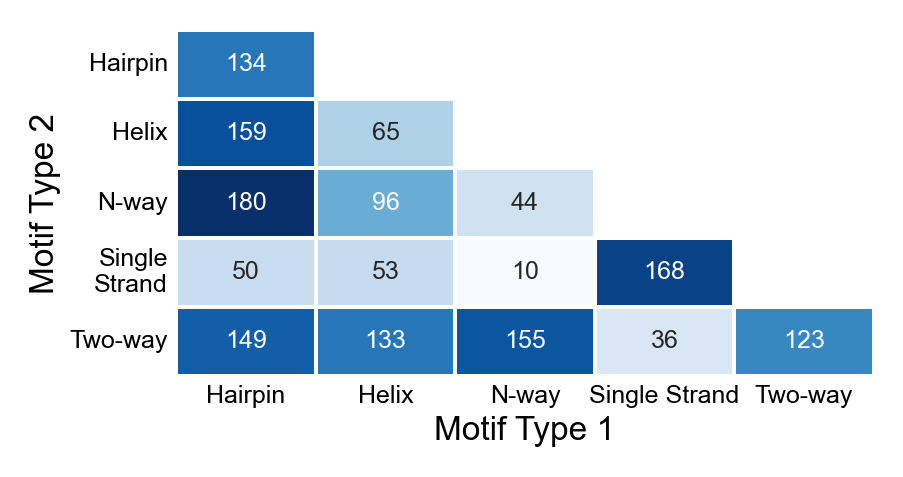

In [169]:
def motif_type_heatmap(df, ax):
    """Create heatmap showing motif type interactions.

    Args:
        df: DataFrame containing motif data with motif_1_type and motif_2_type columns
        ax: matplotlib axes object to plot on

    Returns:
        ax: matplotlib axes object with heatmap
    """
    # Create pivot table of counts
    pivot = pd.crosstab(df["motif_2_type"], df["motif_1_type"])

    # Create heatmap
    ax = sns.heatmap(
        pivot,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
        mask=pivot == 0,  # Hide cells with value 0
        linewidths=0.5,  # Add small space between boxes
        linecolor="white",  # White lines for subtle separation
    )
    # Get current tick labels and modify "Single Strand" to "Single\nStrand"
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    y_labels = [label.get_text() for label in ax.get_yticklabels()]

    # Replace "Single Strand" with "Single\nStrand" in both x and y labels
    x_labels = [label.replace("Single Strand", "Single\nStrand") for label in x_labels]
    y_labels = [label.replace("Single Strand", "Single\nStrand") for label in y_labels]

    # Set the modified labels
    ax.set_yticklabels(y_labels)
    # Customize plot
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)
    ax.set_xlabel("Motif Type 1", labelpad=2)
    ax.set_ylabel("Motif Type 2", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    ax.tick_params(width=0, size=0, pad=2)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(3.0, 1.5), dpi=300)
ax = motif_type_heatmap(df_missing_sub, ax)

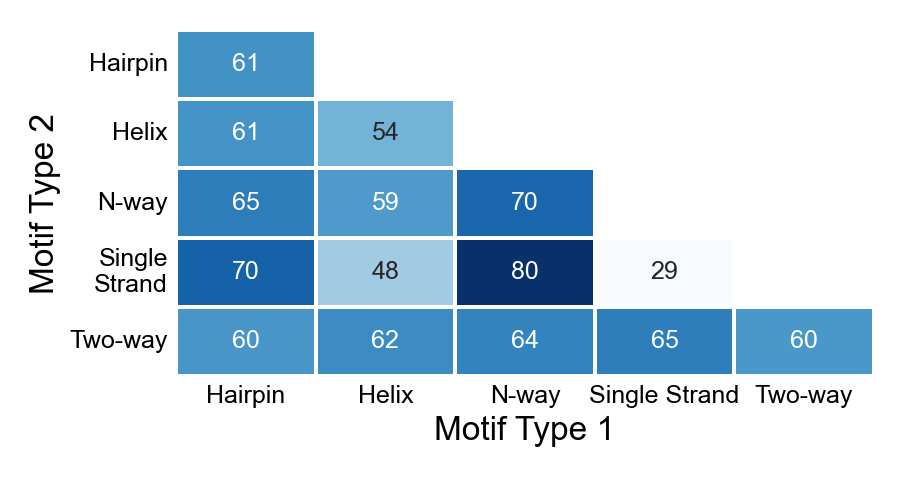

In [170]:
def motif_type_heatmap_percentage(df, ax):
    """Create heatmap showing percentage of motif type interactions found in LORA.

    Args:
        df: DataFrame containing motif interactions with 'in_their_db' column
        ax: matplotlib axes object to plot on

    Returns:
        ax: matplotlib axes object with heatmap
    """
    # All motif interactions
    df_all = df
    # Motif interactions not found in LORA
    df_missing = df[df["in_their_db"] == False]

    # Create pivot tables of counts
    pivot_all = pd.crosstab(df_all["motif_2_type"], df_all["motif_1_type"])
    pivot_missing = pd.crosstab(df_missing["motif_2_type"], df_missing["motif_1_type"])

    # Calculate percentage found (1 - missing/total)
    pivot_percent = (1 - pivot_missing / pivot_all) * 100
    pivot_percent = pivot_percent.fillna(0)

    # Create heatmap
    ax = sns.heatmap(
        pivot_percent,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        cbar=False,
        ax=ax,
        mask=pivot_all == 0,  # Hide cells with no interactions
        linewidths=0.5,  # Add small space between boxes
        linecolor="white",  # White lines for subtle separation
    )

    # Get current tick labels and modify "Single Strand" to "Single\nStrand"
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    y_labels = [label.get_text() for label in ax.get_yticklabels()]

    # Replace "Single Strand" with "Single\nStrand" in both x and y labels
    x_labels = [label.replace("Single Strand", "Single\nStrand") for label in x_labels]
    y_labels = [label.replace("Single Strand", "Single\nStrand") for label in y_labels]

    # Set the modified labels
    ax.set_yticklabels(y_labels)
    # Customize plot
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)
    ax.set_xlabel("Motif Type 1", labelpad=2)
    ax.set_ylabel("Motif Type 2", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    ax.tick_params(width=0, size=0, pad=2)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(3.0, 1.5), dpi=300)
ax = motif_type_heatmap_percentage(df_sub, ax)

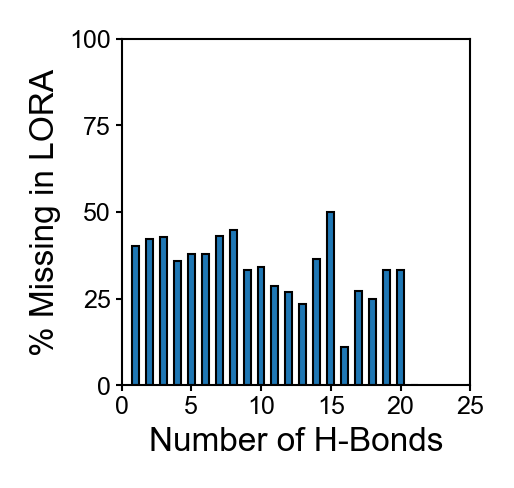

In [ ]:
def histogram_num_hbonds(df, ax):
    """Create histogram showing percentage of missing tertiary contacts by number of H-bonds.

    Args:
        df: DataFrame containing all tertiary contact data, with 'in_their_db' column
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    # All counts by number of H-bonds
    all_counts = df["num_hbonds"].value_counts().sort_index()
    # Missing = in_their_db == False (or 0)
    missing_counts = (
        df[df["in_their_db"] == 0]["num_hbonds"].value_counts().sort_index()
    )

    # Calculate percentage missing
    percent_missing = (missing_counts / all_counts * 100).fillna(0)

    # Plot histogram
    ax.bar(
        percent_missing.index,
        percent_missing.values,
        edgecolor="black",
        width=0.5,
        linewidth=0.5,
    )
    ax.set_xlim(0, 25)
    ax.set_xticks([0, 5, 10, 15, 20, 25])
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_ylabel("% Missing in LORA", labelpad=2)
    ax.set_xlabel("Number of H-Bonds", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = histogram_num_hbonds(df_sub, ax)

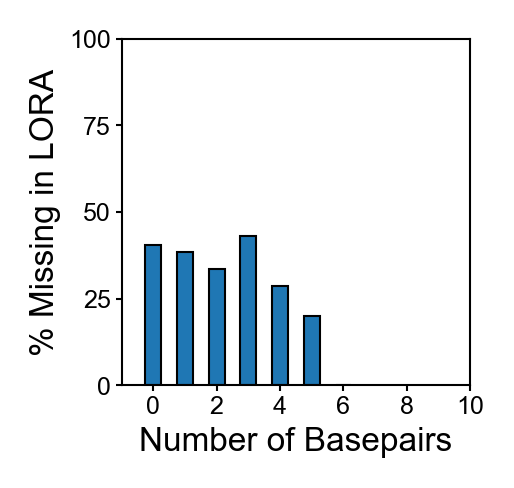

In [ ]:
def histogram_num_basepairs(df, ax):
    """Create histogram showing percentage of missing tertiary contacts by number of basepairs.

    Args:
        df: DataFrame containing all tertiary contact data, with 'in_their_db' column
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    # Calculate counts for each number of basepairs
    all_counts = df["num_basepairs"].value_counts().sort_index()
    missing_counts = (
        df[df["in_their_db"] == 0]["num_basepairs"].value_counts().sort_index()
    )

    # Calculate percentage missing
    percent_missing = (missing_counts / all_counts * 100).fillna(0)

    # Plot histogram
    ax.bar(
        percent_missing.index,
        percent_missing.values,
        edgecolor="black",
        width=0.5,
        linewidth=0.5,
    )
    ax.set_xlim(-1, 10)
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_ylabel("% Missing in LORA", labelpad=2)
    ax.set_xlabel("Number of Basepairs", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = histogram_num_basepairs(df_sub, ax)

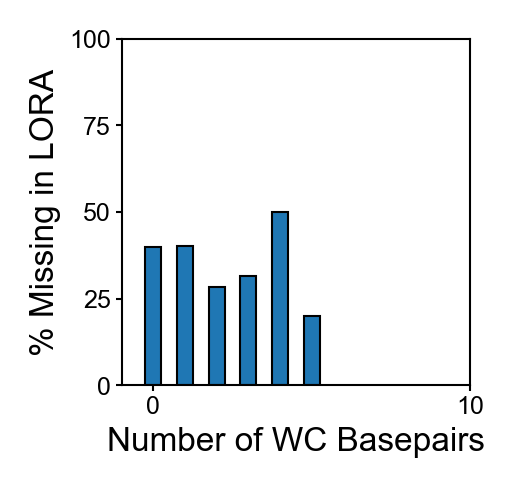

In [ ]:
def histogram_num_wc_basepairs(df, ax):
    """Create histogram showing percentage of missing tertiary contacts by number of WC basepairs.

    Args:
        df: DataFrame containing all tertiary contact data, with 'in_their_db' column
        ax: matplotlib axis to plot on

    Returns:
        matplotlib axis with plot
    """
    # Calculate counts for each number of WC basepairs
    all_counts = df["num_wc_pairs"].value_counts().sort_index()
    missing_counts = (
        df[df["in_their_db"] == False]["num_wc_pairs"].value_counts().sort_index()
    )

    # Calculate percentage missing
    percent_missing = (missing_counts / all_counts * 100).fillna(0)

    # Plot histogram
    ax.bar(
        percent_missing.index,
        percent_missing.values,
        edgecolor="black",
        width=0.5,
        linewidth=0.5,
    )
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_ylabel("% Missing in LORA", labelpad=2)
    ax.set_xlabel("Number of WC Basepairs", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    return ax


# Call the function
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
ax = histogram_num_wc_basepairs(df_sub, ax)

In [175]:
df_missing = df.query("in_their_db == 0")
df_missing.sort_values(by="num_hbonds", ascending=False)

,motif_1_id,motif_2_id,in_our_db,in_their_db,pdb_id,is_motif_1_unique,is_motif_2_unique,motif_1_type,motif_2_type,motif_1_size,...,num_basepairs,basepair_hbond_score,wc_basepair_hbond_score,num_wc_pairs,num_external_hbonds,num_external_base_hbonds,num_ligand_hbonds,is_isolatable,num_external_basepairs,num_external_wc_basepairs
1411,HAIRPIN-8-GUGAAGAUGC-6VWL-1,NWAY-18-11-7-7-6-5-5-4-2-2-CGUACCUUUUGUAUAAUGG...,1,0,6VWL,0,0,Hairpin,N-way,8,...,3,3.211807,1.790530,1,138,0,0,0,0,0
36,HAIRPIN-7-CUUCCUGCG-2Z75-1,SSTRAND-9-GGGCAGGAA-2Z75-1,1,0,2Z75,1,1,Hairpin,Single Strand,7,...,3,8.060776,8.060776,3,9,0,0,0,0,0
616,SSTRAND-13-GUAGUUGGAUCUU-6D9J-1,SSTRAND-9-AUUAAUCAA-6D9J-1,1,0,6D9J,1,1,Single Strand,Single Strand,13,...,2,2.528802,1.894097,1,38,0,0,0,0,0
2913,HAIRPIN-7-UUGAUCCUG-7MQA-1,SSTRAND-8-AGGGAUCA-7MQA-1,1,0,7MQA,1,1,Hairpin,Single Strand,7,...,3,7.080944,7.080944,3,16,0,0,0,0,0
3879,HAIRPIN-10-GUGCAGCCCGUC-7O7Z-1,SSTRAND-12-UACAGGGCUUUU-7O7Z-1,1,0,7O7Z,1,1,Hairpin,Single Strand,10,...,4,9.521843,9.521843,4,14,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,HAIRPIN-18-CGGACUCUUGCAGCACGAGG-6ZU5-1,TWOWAY-1-0-UCG-CA-6ZU5-1,1,0,6ZU5,0,1,Hairpin,Two-way,18,...,0,0.000000,0.000000,0,50,0,0,0,0,0
1773,HAIRPIN-18-CGGACUCUUGCAGCACGAGG-6ZU5-1,TWOWAY-5-4-UGGAGGC-GCGAAG-6ZU5-1,1,0,6ZU5,0,1,Hairpin,Two-way,18,...,0,0.000000,0.000000,0,60,0,0,0,0,0
2120,HAIRPIN-6-CUGGAAAG-7AC7-1,TWOWAY-6-3-CUGCGAAG-UGGAG-7AC7-1,1,0,7AC7,0,0,Hairpin,Two-way,6,...,0,0.000000,0.000000,0,28,0,0,0,0,0
526,NWAY-10-9-8-UAGAGGGACAAG-CUGGCAUGCUA-CCCGAGAUU...,NWAY-17-15-2-2-GCUCAGCGUGUGCCUACCC-GGUAACCCGUU...,1,0,6D9J,0,0,N-way,N-way,10-9-8,...,0,0.000000,0.000000,0,93,0,0,0,0,0


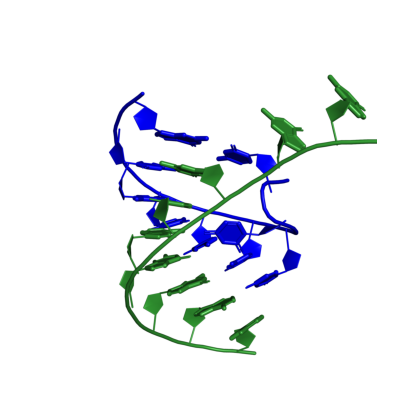

In [180]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
load_and_fit_image_to_subplot(
    "../../figures/images/lora_missed_1.png",
    ax,
)

In [ ]:
def expand_subplot_coords(coords, percent):
    """
    Expand the subplot coordinates by a given percent.

    Parameters
    ----------
    coords : list or tuple of 4 floats
        The [x, y, width, height] coordinates of the subplot (all between 0 and 1).
    percent : float
        The percent to expand the subplot (e.g., 0.1 for 10%).

    Returns
    -------
    list of 4 floats
        The expanded [x, y, width, height] coordinates.
    """
    x, y, w, h = coords
    # Calculate the amount to expand in each direction
    dw = w * percent
    dh = h * percent
    # Expand equally in all directions
    new_x = x - dw / 2
    new_y = y - dh / 2
    new_w = w + dw
    new_h = h + dh
    # Ensure the coordinates stay within [0, 1]
    new_x = max(0, new_x)
    new_y = max(0, new_y)
    new_w = min(1 - new_x, new_w)
    new_h = min(1 - new_y, new_h)
    return [new_x, new_y, new_w, new_h]

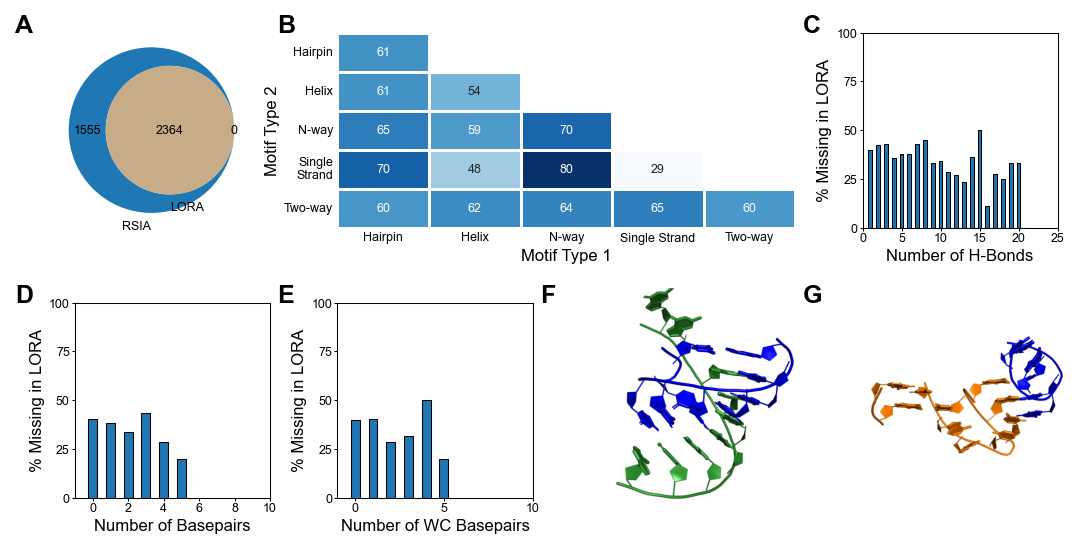

In [ ]:
fig_size = (7, 4)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.30, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
coords_list = merge_sequential_coords(coords_list, 1, 2)
new_coords = [
    coords_list[0][0] - 0.02,
    coords_list[0][1],
    coords_list[0][2],
    coords_list[0][3],
]
fig = plt.figure(figsize=fig_size, dpi=150)
# Create subplots
ax1 = fig.add_axes(new_coords)
plot_overlap_venn(df, ax1)

ax2 = fig.add_axes(coords_list[1])
motif_type_heatmap_percentage(df, ax2)

ax3 = fig.add_axes(coords_list[2])
histogram_num_hbonds(df, ax3)

ax4 = fig.add_axes(coords_list[3])
histogram_num_basepairs(df, ax4)

ax5 = fig.add_axes(coords_list[4])
histogram_num_wc_basepairs(df, ax5)

new_coords = expand_subplot_coords(coords_list[5], 0.15)
ax6 = fig.add_axes(new_coords)
load_and_fit_image_to_subplot(
    "../../figures/images/lora_missed_1.png",
    ax6,
)

new_coords = expand_subplot_coords(coords_list[6], 0.15)
ax7 = fig.add_axes(new_coords)
load_and_fit_image_to_subplot(
    "../../figures/images/lora_missed_2.png",
    ax7,
)

letters = ["A", "B", "C", "D", "E", "F", "G"]
for i, letter in enumerate(letters):
    fig.text(
        coords_list[i][0] - 0.4 / fig_size[0],
        coords_list[i][1] + 1.3 / fig_size[1],
        letter,
        fontsize=12,
        weight="bold",
        fontname="Arial",
    )
    